Built graph with 47 nodes, 41 edges @ thr=0.6
Connected components: 28 | Largest size: 17
Seed: AAPL | Reachable: 17 nodes

Top-10 degree nodes:
SPY     13
QQQ     12
AMAT     6
AVGO     5
META     4
NVDA     4
MSFT     4
QCOM     4
AMZN     4
IWM      4

BFS distances (seed first 10):
AAPL     0
SPY      1
QQQ      1
MSFT     2
NVDA     2
AMZN     2
GOOGL    2
META     2
AVGO     2
AMD      2

DFS pre-order (first 15): ['AAPL', 'SPY', 'MSFT', 'AMZN', 'META', 'QQQ', 'NVDA', 'AVGO', 'QCOM', 'AMAT', 'AMD', 'GOOGL', 'IWM', 'BAC', 'JPM']

Saved:
 - C:\Users\adity\Downloads\Learn_DSA_Quant\Level-24\corr_graph_nodes.csv
 - C:\Users\adity\Downloads\Learn_DSA_Quant\Level-24\corr_graph_edges.csv
 - C:\Users\adity\Downloads\Learn_DSA_Quant\Level-24\corr_graph_top5_per_component.csv


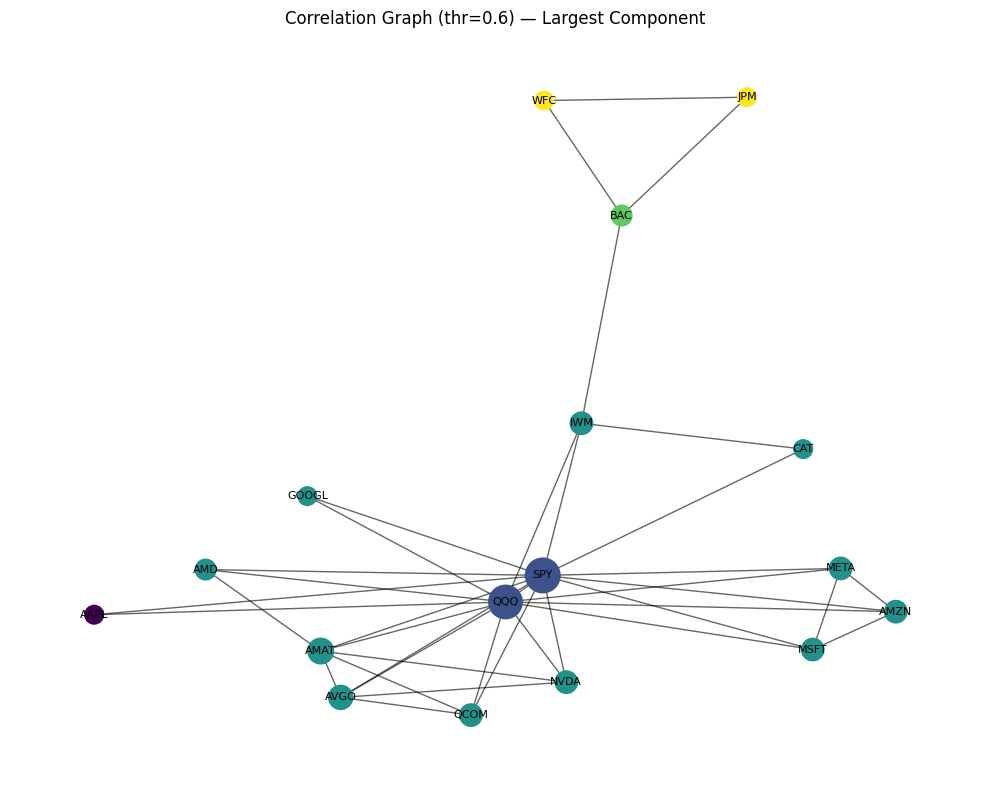

In [1]:
# Step 24 — Graphs BFS/DFS + Correlation Graphs (one cell, hardened)

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import networkx as nx
from pathlib import Path
from typing import List, Optional

# -------------------- User params --------------------
UNIVERSE: List[str] = [
    "AAPL","MSFT","NVDA","AMZN","GOOGL","META","TSLA","AVGO","BRK-B","JPM","V","XOM","LLY",
    "UNH","WMT","MA","PG","HD","COST","JNJ","NFLX","PEP","BAC","KO","ABBV","MRK","CSCO",
    "CRM","ADBE","AMD","QCOM","INTC","AMAT","ORCL","NKE","MCD","WFC","CAT","IBM","GE",
    "UPS","BA","T","VZ","SPY","QQQ","IWM"
]
LOOKBACK_YEARS: int = 2
RET_KIND: str = "simple"   # "simple" or "log"
CORR_THRESHOLD: float = 0.6   # edge if corr >= this threshold
SEED_TICKER: str = "AAPL"     # for BFS/DFS
OUT_DIR = Path(r"C:\Users\adity\Downloads\Learn_DSA_Quant\Level-24")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# -------------------- Helpers --------------------
def download_close(tickers: List[str], years=2) -> pd.DataFrame:
    try:
        df = yf.download(" ".join(tickers), period=f"{years}y", interval="1d",
                         auto_adjust=True, progress=False, threads=True)
        if df.empty:
            return pd.DataFrame()
        if isinstance(df.columns, pd.MultiIndex):
            if "Close" in df.columns.get_level_values(0):
                px = df["Close"].copy()
            else:
                lvl0 = df.columns.get_level_values(0)
                px = df[lvl0.unique()[-1]].copy()
        else:
            if "Close" in df.columns:
                px = df[["Close"]].copy()
                if len(tickers) == 1:
                    px.columns = [tickers[0]]
            else:
                px = pd.DataFrame()
        px = px.dropna(how="all").ffill().dropna(how="any")
        return px
    except Exception:
        return pd.DataFrame()

def make_synth(tickers: List[str], years=2, seed=24) -> pd.DataFrame:
    np.random.seed(seed)
    n = years * 252
    dates = pd.bdate_range(end=pd.Timestamp.today().normalize(), periods=n)
    # Create correlated GBM via a random low-rank factor structure
    k = max(3, min(8, len(tickers)//5))      # few latent factors
    F = np.random.randn(n, k) * 0.8          # factor realizations
    L = np.random.randn(len(tickers), k)     # loadings
    idio = 0.6 * np.random.randn(n, len(tickers))
    X = F @ L.T + idio
    # scale to reasonable vol
    X = X / X.std(axis=0) * 0.015            # ~1.5% daily vol
    price = 100 * np.exp(np.cumsum(X, axis=0))
    return pd.DataFrame(price, index=dates, columns=tickers)

def returns(px: pd.DataFrame, kind="simple") -> pd.DataFrame:
    r = px.pct_change() if kind == "simple" else np.log(px/px.shift(1))
    return r.dropna(how="any")

def build_graph_from_corr(C: pd.DataFrame, thr: float) -> nx.Graph:
    G = nx.Graph()
    # add nodes first
    for t in C.columns:
        G.add_node(t)
    # add edges above threshold
    for i, ti in enumerate(C.columns):
        for j, tj in enumerate(C.columns):
            if j <= i:
                continue
            rho = float(C.iloc[i, j])
            if np.isfinite(rho) and rho >= thr:
                G.add_edge(ti, tj, weight=rho)
    return G

def bfs_layers(G: nx.Graph, source: str):
    """Return dict: node -> BFS distance (layers). Unreachable nodes omitted."""
    if source not in G:
        return {}
    return nx.single_source_shortest_path_length(G, source)

def dfs_order(G: nx.Graph, source: str):
    """Return DFS pre-order list."""
    if source not in G:
        return []
    return list(nx.dfs_preorder_nodes(G, source))

# -------------------- Data --------------------
px = download_close(UNIVERSE, LOOKBACK_YEARS)
if px.empty or px.shape[1] < max(10, len(UNIVERSE)//3):
    print("Using synthetic data fallback for coverage.")
    px = make_synth(UNIVERSE, LOOKBACK_YEARS)

# Clean & align
px = px.sort_index().dropna(how="any")
# If some tickers missing after cleaning, keep intersection
present = [c for c in UNIVERSE if c in px.columns]
if len(present) < 5:
    present = list(px.columns)
px = px[present]

# -------------------- Correlations --------------------
r = returns(px, kind=RET_KIND)
# Optional: winsorize tails to reduce outlier influence
q = r.quantile([0.01, 0.99])
r = r.clip(lower=q.loc[0.01], upper=q.loc[0.99], axis=1)

C = r.corr()   # NxN correlation

# -------------------- Graph --------------------
G = build_graph_from_corr(C, CORR_THRESHOLD)
components = list(nx.connected_components(G))
comp_sizes = sorted([(len(c), idx) for idx, c in enumerate(components)], reverse=True)

# Degree centrality (simple degree)
deg_series = pd.Series(dict(G.degree()), name="degree").sort_values(ascending=False)

# Largest component details
largest_comp_idx = comp_sizes[0][1] if comp_sizes else None
largest_nodes = sorted(list(components[largest_comp_idx])) if largest_comp_idx is not None else []

# -------------------- BFS / DFS from seed --------------------
if SEED_TICKER not in G:
    # pick a popular node (highest degree) as backup
    SEED_TICKER = deg_series.index[0] if not deg_series.empty else list(G.nodes())[0]

bfs_dist = bfs_layers(G, SEED_TICKER)
dfs_pre  = dfs_order(G, SEED_TICKER)

# -------------------- Tables & exports --------------------
# Edge list with weights
edges = []
for u, v, w in G.edges(data=True):
    edges.append({"u":u, "v":v, "corr": float(w.get("weight", np.nan))})
edges_df = pd.DataFrame(edges).sort_values("corr", ascending=False)

# Node table with degree and component id
node_rows = []
node_to_comp = {}
for comp_id, comp in enumerate(components):
    for n in comp:
        node_to_comp[n] = comp_id

for n in G.nodes():
    node_rows.append({
        "ticker": n,
        "degree": int(G.degree(n)),
        "component_id": node_to_comp.get(n, -1),
        "bfs_dist_from_seed": bfs_dist.get(n, np.nan)
    })
nodes_df = pd.DataFrame(node_rows).sort_values(["component_id","degree"], ascending=[True, False])

# Top-5 by degree per component
top_by_comp = (
    nodes_df.sort_values(["component_id","degree"], ascending=[True, False])
            .groupby("component_id")
            .head(5)
)

out_nodes = OUT_DIR / "corr_graph_nodes.csv"
out_edges = OUT_DIR / "corr_graph_edges.csv"
out_comp  = OUT_DIR / "corr_graph_top5_per_component.csv"
nodes_df.to_csv(out_nodes, index=False)
edges_df.to_csv(out_edges, index=False)
top_by_comp.to_csv(out_comp, index=False)

print(f"Built graph with {G.number_of_nodes()} nodes, {G.number_of_edges()} edges @ thr={CORR_THRESHOLD}")
print(f"Connected components: {len(components)} | Largest size: {len(largest_nodes)}")
print(f"Seed: {SEED_TICKER} | Reachable: {len(bfs_dist)} nodes\n")
print("Top-10 degree nodes:")
print(deg_series.head(10).to_string())
print("\nBFS distances (seed first 10):")
print(pd.Series(bfs_dist).sort_values().head(10).to_string())
print("\nDFS pre-order (first 15):", dfs_pre[:15])
print(f"\nSaved:\n - {out_nodes}\n - {out_edges}\n - {out_comp}")

# -------------------- Plot --------------------
# Spring layout on largest component for readability
plt.figure(figsize=(10, 8))
if largest_nodes:
    H = G.subgraph(largest_nodes).copy()
else:
    H = G.copy()

pos = nx.spring_layout(H, seed=42, weight="weight", k=None)  # force-directed
# Node sizes by degree (scaled)
deg_H = np.array([H.degree(n) for n in H.nodes()])
size = 100 + 40*deg_H

# Color nodes by BFS distance bucket (if reachable); fallback to 0
dist_map = bfs_dist
node_color = [dist_map.get(n, 0) for n in H.nodes()]

nx.draw_networkx_nodes(H, pos, node_size=size, node_color=node_color)
nx.draw_networkx_edges(H, pos, width=1.0, alpha=0.6)
nx.draw_networkx_labels(H, pos, font_size=8)
plt.title(f"Correlation Graph (thr={CORR_THRESHOLD}) — Largest Component")
plt.axis("off")
plt.tight_layout()
plt.show()
